In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

In [14]:
data = pd.read_csv('/content/A20000021_Ahmed_Dataset.csv', encoding='ISO-8859-1', header=None, on_bad_lines='warn')
data.columns = ["Product", "Rating", "Ratings Count", "Availability"]
data = data.dropna().reset_index(drop=True)
data.head()

,Product,Rating,Ratings Count,Availability
0,Xiaomi Redmi A3 3GB RAM | 64GB ROM 6.71 Inches...,3.5 out of 5 stars,63 ratings,In Stock
1,Xiaomi Redmi Note 12 Dual SIM Smartphone with ...,4.1 out of 5 stars,25316 ratings,In Stock
2,Amazon Essentials Men's Digital Chronograph Bl...,4.3 out of 5 stars,743 ratings,In Stock
3,LUENX Aviator Sunglasses for Men Square Polari...,4.5 out of 5 stars,4587 ratings,In Stock
4,SAMSUNG Galaxy S24 Ultra Cell Phone 512GB AI S...,4.5 out of 5 stars,226 ratings,Only 3 left in stock - order soon.


In [15]:
def parse_rating(rating_str):
    try:
        return float(rating_str.split(" out of ")[0])
    except:
        return np.nan

data["Rating"] = data["Rating"].apply(parse_rating)
data['User'] = data.index

In [16]:
ratings_matrix = data.pivot_table(index='User', columns='Product', values='Rating')

In [17]:
tnu = len(data["Ratings Count"].unique())
tni = len(data["Product"].unique())

In [18]:
ratings_per_item = data.groupby("Product")["Rating"].count()

active_users = {"U1": 2, "U2": 3, "U3": 5}

target_items = {"I1": 0.04, "I2": 0.10}

In [19]:
def count_common_users_and_items(active_user_ratings, all_user_ratings):
    common_users, co_rated_items = 0, 0
    for user_ratings in all_user_ratings:
        common = ~np.isnan(active_user_ratings) & ~np.isnan(user_ratings)
        common_users += np.sum(common)
        co_rated_items += np.sum(common & (active_user_ratings == user_ratings))
    return common_users, co_rated_items

In [20]:
#2D array
common_users_items = []
for user in active_users.keys():
    common_users, co_rated_items = count_common_users_and_items(data["Rating"], data["Rating"])
    common_users_items.append([common_users, co_rated_items])

common_users_items = np.array(common_users_items)
common_users_items_sorted = common_users_items[np.argsort(-common_users_items[:, 0])]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


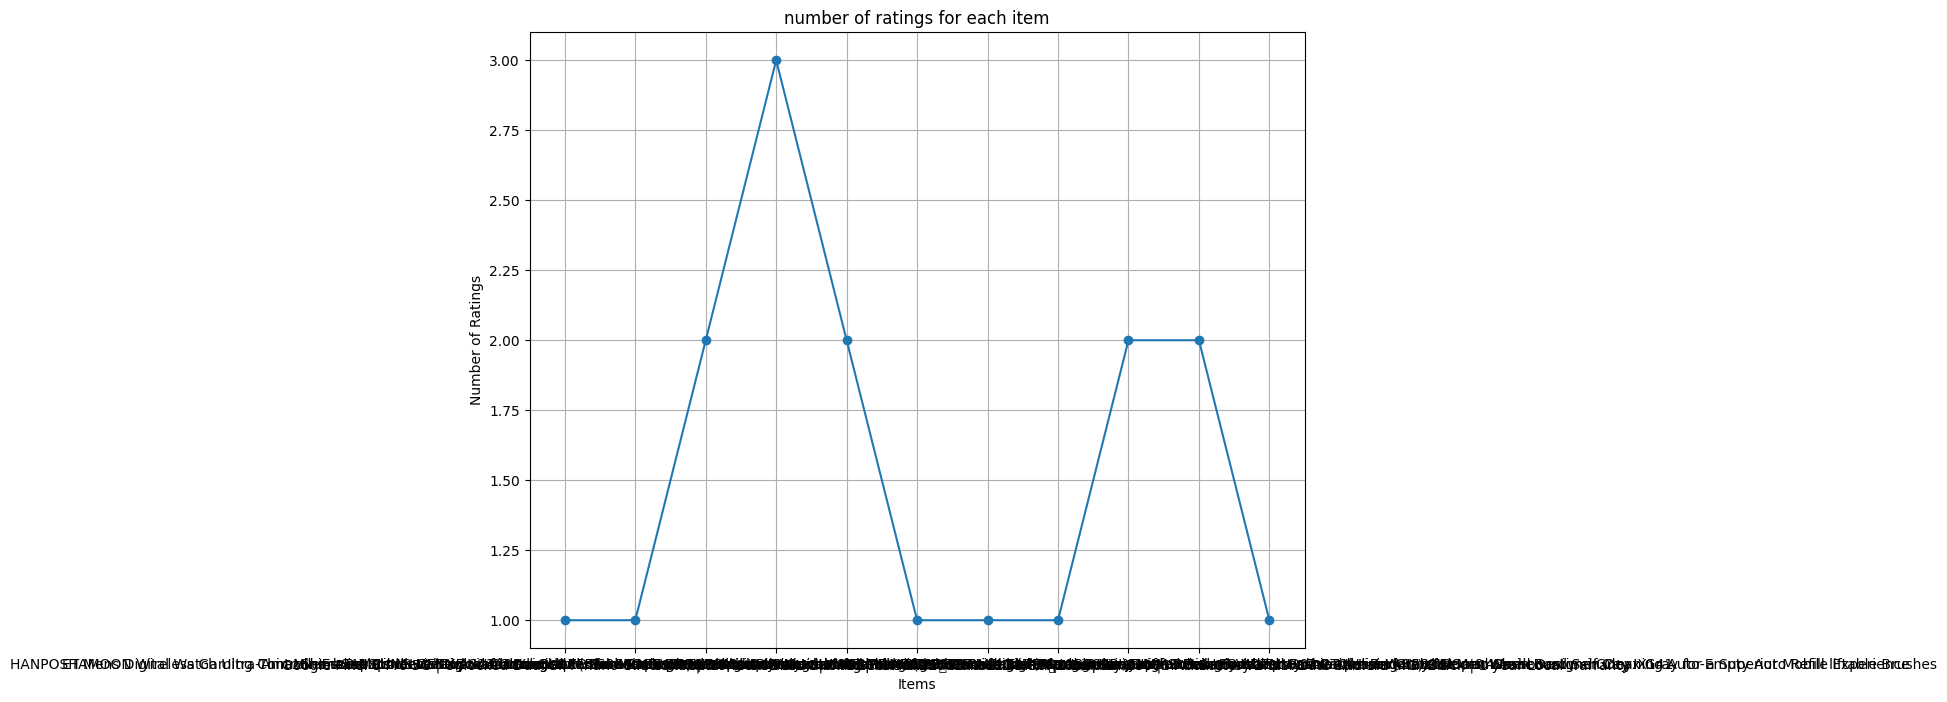

In [30]:
# quantity of ratings per item
plt.figure(figsize=(10, 8))
plt.plot(ratings_per_item.index, ratings_per_item.values, marker="o")
plt.title("number of ratings for each item")
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.grid()
plt.show()

In [26]:
thresholds = {}
for user in active_users.keys():
    thresholds[user] = max([common_users for common_users in common_users_items[:, 0] if common_users >= 0.3 * len(data)])

thresholds

{'U1': 289, 'U2': 289, 'U3': 289}

In [27]:
def compute_cosine_similarity(ratings):
    ratings_matrix = ratings.fillna(0).values
    return cosine_similarity(ratings_matrix)

In [28]:
def compute_pearson_similarity(ratings):
    import numpy as np
    from scipy.stats import pearsonr

    if isinstance(ratings, pd.DataFrame):
        ratings = ratings.to_numpy()

    n_users = ratings.shape[0]
    similarity_matrix = np.zeros((n_users, n_users))

    for i in range(n_users):
        for j in range(n_users):
            if i != j:
                common = ~np.isnan(ratings[i]) & ~np.isnan(ratings[j])
                if np.sum(common) > 1:
                    similarity_matrix[i, j] = pearsonr(ratings[i][common], ratings[j][common])[0]

    return similarity_matrix

In [29]:
def compute_discounted_similarity(similarity_matrix, threshold):

    discounted_similarity_matrix = similarity_matrix.copy()
    discounted_similarity_matrix[discounted_similarity_matrix < threshold] = 0
    return discounted_similarity_matrix

In [31]:
def get_top_k(similarity_matrix, k):
    top_k_indices = {}
    for i, similarities in enumerate(similarity_matrix):
        sorted_indices = np.argsort(-similarities)
        top_k_indices[i] = sorted_indices[:int(k * len(similarities))]
    return top_k_indices

In [32]:
def predict_ratings(similarity_matrix, ratings, top_k_indices):
    predictions = {}
    ratings = np.atleast_2d(ratings)  # Ensures ratings is always 2D
    for user, neighbors in top_k_indices.items():
        user_predictions = []
        for item in range(ratings.shape[1]):
            if np.isnan(ratings[user, item]):
                weighted_sum = sum(
                    similarity_matrix[user, neighbor] * ratings[neighbor, item]
                    for neighbor in neighbors if not np.isnan(ratings[neighbor, item])
                )
                weight_sum = sum(
                    abs(similarity_matrix[user, neighbor])
                    for neighbor in neighbors if not np.isnan(ratings[neighbor, item])
                )
                user_predictions.append(weighted_sum / weight_sum if weight_sum != 0 else np.nan)
            else:
                user_predictions.append(ratings[user, item])
        predictions[user] = user_predictions
    return predictions

In [33]:
def calculate_predictions_diff(predictions_1, predictions_2):
    diff_sum = 0
    count = 0
    for user in predictions_1:
        for item, pred_1 in enumerate(predictions_1[user]):
            pred_2 = predictions_2.get(user, [])[item]
            if not np.isnan(pred_1) and not np.isnan(pred_2):
                diff_sum += abs(pred_1 - pred_2)
                count += 1
    return diff_sum / count if count > 0 else np.nan

def mean_center(matrix):
    row_means = np.nanmean(matrix, axis=1, keepdims=True)

    mean_centered = matrix - row_means
    mean_centered[np.isnan(matrix)] = np.nan

    return mean_centered

In [35]:
#1.1
cosine_sim = compute_cosine_similarity(ratings_matrix)

top_users_cosine = get_top_k(cosine_sim, 0.2)


predictions_cosine = predict_ratings(cosine_sim, ratings_matrix, top_users_cosine)

discounted_cosine_sim = compute_discounted_similarity(cosine_sim, threshold=3)

top_users_discounted = get_top_k(discounted_cosine_sim, 0.2)

predictions_discounted = predict_ratings(discounted_cosine_sim, ratings_matrix, top_users_discounted)

print("Top users (Cosine Similarity):")
print(top_users_cosine)
print("\nTop users (Discounted Similarity):")
print(top_users_discounted)

print("\nPredictions (Cosine Similarity):")
print(predictions_cosine)
print("\nPredictions (Discounted Similarity):")
print(predictions_discounted)

Top users (Cosine Similarity):
{0: array([ 0, 13, 14]), 1: array([ 1, 14,  0]), 2: array([ 2,  0, 14]), 3: array([16,  3, 14]), 4: array([ 4,  0, 14]), 5: array([ 5, 15,  0]), 6: array([ 6,  0, 14]), 7: array([ 7,  0, 14]), 8: array([ 8, 11, 10]), 9: array([ 9,  0, 14]), 10: array([ 8, 11, 10]), 11: array([ 8, 11, 10]), 12: array([12,  0, 14]), 13: array([ 0, 13, 14]), 14: array([ 1, 14,  0]), 15: array([ 5, 15,  0]), 16: array([16,  3, 14])}

Top users (Discounted Similarity):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Predictions (Cosine Similarity):
{0: [nan, nan, nan, nan, nan, nan, nan, nan, 3.5, nan, nan], 1: [na

In [36]:
#1.2
mean_centered_ratings = mean_center(ratings_matrix)
cosine_sim_bias = compute_cosine_similarity(mean_centered_ratings)

top_users_cosine_bias = get_top_k(cosine_sim_bias, 0.2)


predictions_cosine_bias = predict_ratings(cosine_sim_bias, ratings_matrix, top_users_cosine_bias)

discounted_cosine_sim_bias = compute_discounted_similarity(cosine_sim_bias, threshold=3)
top_users_discounted_bias = get_top_k(discounted_cosine_sim_bias, 0.2)

predictions_discounted_bias = predict_ratings(discounted_cosine_sim_bias, ratings_matrix, top_users_discounted_bias)

print("Top users (Cosine Similarity with Bias Adjustment):")
print(top_users_cosine_bias)
print("\nTop users (Discounted Cosine Similarity with Bias Adjustment):")
print(top_users_discounted_bias)

print("\nPredictions (Cosine Similarity with Bias Adjustment):")
print(predictions_cosine_bias)
print("\nPredictions (Discounted Cosine Similarity with Bias Adjustment):")
print(predictions_discounted_bias)

Top users (Cosine Similarity with Bias Adjustment):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Top users (Discounted Cosine Similarity with Bias Adjustment):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Predictions (Cosine Similarity with Bias Adjustment

In [37]:
#1.3
pearson_sim = compute_pearson_similarity(ratings_matrix)

top_users_pearson = get_top_k(pearson_sim, 0.2)

predictions_pearson = predict_ratings(pearson_sim, ratings_matrix, top_users_pearson)

discounted_pearson_sim = compute_discounted_similarity(pearson_sim, threshold=3)

top_users_discounted_pearson = get_top_k(discounted_pearson_sim, 0.2)

predictions_discounted_pearson = predict_ratings(discounted_pearson_sim, ratings_matrix, top_users_discounted_pearson)

print("Top users (Pearson Correlation Coefficient):")
print(top_users_pearson)
print("\nTop users (Discounted Pearson Correlation Coefficient):")
print(top_users_discounted_pearson)

print("\nPredictions (Pearson Correlation Coefficient):")
print(predictions_pearson)
print("\nPredictions (Discounted Pearson Correlation Coefficient):")
print(predictions_discounted_pearson)

Top users (Pearson Correlation Coefficient):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Top users (Discounted Pearson Correlation Coefficient):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Predictions (Pearson Correlation Coefficient):
{0: [nan, nan, nan

In [38]:
# 2.1
cosine_sim = compute_cosine_similarity(ratings_matrix)

top_items_cosine = get_top_k(cosine_sim, 0.25)

predictions_cosine = predict_ratings(cosine_sim, ratings_matrix, top_items_cosine)

discounted_cosine_sim = compute_discounted_similarity(cosine_sim, threshold=8)

top_items_discounted_cosine = get_top_k(discounted_cosine_sim, 0.2)

predictions_discounted_cosine = predict_ratings(discounted_cosine_sim, ratings_matrix, top_items_discounted_cosine)

print("Top items (Cosine Similarity):")
print(top_items_cosine)
print("\nTop items (Discounted Cosine Similarity):")
print(top_items_discounted_cosine)

print("\nPredictions (Cosine Similarity):")
print(predictions_cosine)
print("\nPredictions (Discounted Cosine Similarity):")
print(predictions_discounted_cosine)

Top items (Cosine Similarity):
{0: array([ 0, 13, 14, 12]), 1: array([ 1, 14,  0, 13]), 2: array([ 2,  0, 14, 13]), 3: array([16,  3, 14, 13]), 4: array([ 4,  0, 14, 13]), 5: array([ 5, 15,  0, 14]), 6: array([ 6,  0, 14, 13]), 7: array([ 7,  0, 14, 13]), 8: array([ 8, 11, 10, 14]), 9: array([ 9,  0, 14, 13]), 10: array([ 8, 11, 10, 14]), 11: array([ 8, 11, 10, 14]), 12: array([12,  0, 14, 13]), 13: array([ 0, 13, 14, 12]), 14: array([ 1, 14,  0, 13]), 15: array([ 5, 15,  0, 14]), 16: array([16,  3, 14, 13])}

Top items (Discounted Cosine Similarity):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Predictions (Cosine Simil

In [39]:
# 2.2
mean_centered_ratings = ratings_matrix - ratings_matrix.mean(axis=0)

top_items_cosine_bias = get_top_k(cosine_sim_bias, 0.2)

predictions_cosine_bias = predict_ratings(cosine_sim_bias, ratings_matrix, top_items_cosine_bias)

discounted_cosine_sim_bias = compute_discounted_similarity(cosine_sim_bias, threshold=8)

top_items_discounted_cosine_bias = get_top_k(discounted_cosine_sim_bias, 0.2)

predictions_discounted_cosine_bias = predict_ratings(discounted_cosine_sim_bias, ratings_matrix, top_items_discounted_cosine_bias)

print("Top items (Mean-centered Cosine Similarity):")
print(top_items_cosine_bias)
print("\nTop items (Discounted Mean-centered Cosine Similarity):")
print(top_items_discounted_cosine_bias)

print("\nPredictions (Mean-centered Cosine Similarity):")
print(predictions_cosine_bias)
print("\nPredictions (Discounted Mean-centered Cosine Similarity):")
print(predictions_discounted_cosine_bias)

Top items (Mean-centered Cosine Similarity):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Top items (Discounted Mean-centered Cosine Similarity):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Predictions (Mean-centered Cosine Similarity):
{0: [nan, nan, nan

In [40]:
# 2.3
pearson_sim = compute_pearson_similarity(ratings_matrix)

top_items_pearson = get_top_k(pearson_sim, 0.2)

predictions_pearson = predict_ratings(pearson_sim, ratings_matrix, top_items_pearson)

discounted_pearson_sim = compute_discounted_similarity(pearson_sim, threshold=8)

top_items_discounted_pearson = get_top_k(discounted_pearson_sim, 0.2)

predictions_discounted_pearson = predict_ratings(discounted_pearson_sim, ratings_matrix, top_items_discounted_pearson)

print("Top items (Pearson Correlation):")
print(top_items_pearson)
print("\nTop items (Discounted Pearson Correlation):")
print(top_items_discounted_pearson)

print("\nPredictions (Pearson Correlation):")
print(predictions_pearson)
print("\nPredictions (Discounted Pearson Correlation):")
print(predictions_discounted_pearson)

Top items (Pearson Correlation):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Top items (Discounted Pearson Correlation):
{0: array([ 0, 14, 13]), 1: array([ 0, 14, 13]), 2: array([ 0, 14, 13]), 3: array([ 0, 14, 13]), 4: array([ 0, 14, 13]), 5: array([ 0, 14, 13]), 6: array([ 0, 14, 13]), 7: array([ 0, 14, 13]), 8: array([ 0, 14, 13]), 9: array([ 0, 14, 13]), 10: array([ 0, 14, 13]), 11: array([ 0, 14, 13]), 12: array([ 0, 14, 13]), 13: array([ 0, 14, 13]), 14: array([ 0, 14, 13]), 15: array([ 0, 14, 13]), 16: array([ 0, 14, 13])}

Predictions (Pearson Correlation):
{0: [nan, nan, nan, nan, nan, nan, nan, nan, 3.5, nan,